## Volatility

The trully interesting exercises in this chapter are in the _Further Questions_ section. 10.20 and 10.22 are my vavourite ones. I created [dedicated classes for estimating EWMA and GARCH parameters](https://github.com/ilchen/RMaFI/blob/master/volatility/parameter_estimators.py) to tackle problems similar to those scratched in these exercises.

I don't want to repeate the exercises per see, so below you will find calculations inspired by them.

#### Estimating the &lambda; parameter for EWMA

In [1]:
import pandas_datareader.data as web
import datetime

from volatility import parameter_estimators

In [2]:
# Looking at an asset price changes between 7th July 2005 and 7th July 2010
start = datetime.datetime(2005, 7, 27)
end = datetime.datetime(2010, 7, 27)

# I use Yahoo Finance to fetch asset prices, in this case looking at the GBPUSD currency pair
data = web.get_data_yahoo('GBPUSD=X', start, end)
asset_prices_series = data['Adj Close']

In [3]:
# Inspired by exercise by Ex 10.20
ch10_ewma_min_diff = parameter_estimators.EWMAMinimumDifferenceParameterEstimator(asset_prices_series)
print('Optimal value for λ using the minimum difference method: %.5f' % ch10_ewma_min_diff.lamda)

Objective function: -0.00000 after 14 iterations
Optimal value for λ using the minimum difference method: 0.93750


In [4]:
ch10_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices_series)
print('Optimal value for λ when using the EWMA: %.5f' % ch10_ewma.lamda)

Objective function: 11848.63466 after 15 iterations
Optimal value for λ when using the EWMA: 0.95849


#### Estimating the &omega;, &alpha;, and &beta; parameters for GARCH(1, 1)
This takes much longer than the EWMA estimator given that we need to solve a bounded and constrained optimization problem in three parameters as opposed to just a bounded optimization in one variable without any constraints for EWMA.

In [5]:
ch10_garch = parameter_estimators.GARCHParameterEstimator(asset_prices_series)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (ch10_garch.omega, ch10_garch.alpha, ch10_garch.beta))

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Objective function: 11857.54490 after 108 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000000293641, α=0.04649, β=0.94730


### Delving into the volatility of Apple stock

In [6]:
from volatility import volatility_trackers

start = datetime.datetime(2019, 12, 15)
#end = datetime.datetime(2021, 12, 17)
end = datetime.datetime.today()

# I use Yahoo Finance to fetch asset prices, in this case looking at the Apple stock
data = web.get_data_yahoo('AAPL', start, end)
asset_prices_series = data['Adj Close']

# First let's estimate using an EWMA estiator
aapl_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices_series)
aapl_vol_tracker = volatility_trackers.EWMAVolatilityTracker(aapl_ewma.lamda, asset_prices_series)

# And then using GARCH(1, 1)
aapl_garch = parameter_estimators.GARCHParameterEstimator(asset_prices_series)
aapl_garch_vol_tracker = volatility_trackers.GARCHVolatilityTracker(aapl_garch.omega, aapl_garch.alpha,
                                                                    aapl_garch.beta, asset_prices_series)

Objective function: 3401.26598 after 12 iterations
Objective function: 3494.80781 after 126 iterations


#### Visualizing the volatility of Apple stock estimated with the Exponentially Weighted Moving Average (EWMA) model
Using the maximum likelihood method

Text(0, 0.5, 'Closing Price')

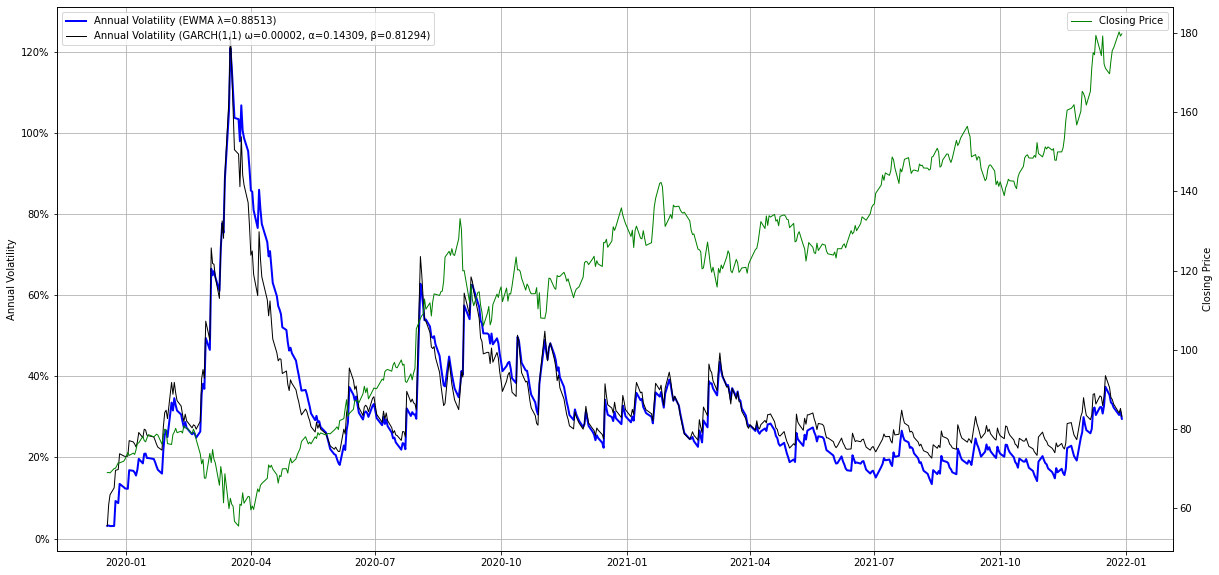

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from math import sqrt

left_lbl, right_lbl = 'Annual Volatility', 'Closing Price'

to_annual_multiplier = sqrt(252)
x = aapl_vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, aapl_vol_tracker.get_annual_volatilities() * 100,
        label='Annual Volatility (EWMA λ=%.5f)' % aapl_ewma.lamda , linewidth=2, color='b')
ax.plot(x, aapl_garch_vol_tracker.get_annual_volatilities() * 100,
        label='Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' % (aapl_garch.omega, aapl_garch.alpha, aapl_garch.beta),
        linewidth=1, color='k')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, aapl_vol_tracker.get_adj_close_prices(), label=right_lbl, linewidth=1, color='g')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl)